You’re optimising an eight-dimensional black-box function, where each of the eight input parameters affects the output, but the internal mechanics are unknown. 

Your objective is to find the parameter combination that maximises the function’s output, such as performance, efficiency or validation accuracy. Because the function is high-dimensional and likely complex, global optimisation is hard, so identifying strong local maxima is often a practical strategy.

For example, imagine you’re tuning an ML model with eight hyperparameters: learning rate, batch size, number of layers, dropout rate, regularisation strength, activation function (numerically encoded), optimiser type (encoded) and initial weight range. Each input set returns a single validation accuracy score between 0 and 1. Your goal is to maximise this score.

In [2]:
import numpy as np
import pandas as pd

In [3]:
inputs_f8 = np.load('function_8/initial_inputs.npy')
outputs_f8 = np.load('function_8/initial_outputs.npy')

In [4]:
print("Inputs (Function 8):", inputs_f8)

Inputs (Function 8): [[0.60499445 0.29221502 0.90845275 0.35550624 0.20166872 0.57533801
  0.31031095 0.73428138]
 [0.17800696 0.56622265 0.99486184 0.21032501 0.32015266 0.70790879
  0.63538449 0.10713163]
 [0.00907698 0.81162615 0.52052036 0.07568668 0.26511183 0.09165169
  0.59241515 0.36732026]
 [0.50602816 0.65373012 0.36341078 0.17798105 0.0937283  0.19742533
  0.7558269  0.29247234]
 [0.35990926 0.24907568 0.49599717 0.70921498 0.11498719 0.28920692
  0.55729515 0.59388173]
 [0.77881834 0.0034195  0.33798313 0.51952778 0.82090699 0.53724669
  0.5513471  0.66003209]
 [0.90864932 0.0622497  0.23825955 0.76660355 0.13233596 0.99024381
  0.68806782 0.74249594]
 [0.58637144 0.88073573 0.74502075 0.54603485 0.00964888 0.74899176
  0.23090707 0.09791562]
 [0.76113733 0.85467239 0.38212433 0.33735198 0.68970832 0.30985305
  0.63137968 0.04195607]
 [0.9849332  0.69950626 0.9988855  0.18014846 0.58014315 0.23108719
  0.49082694 0.31368272]
 [0.11207131 0.43773566 0.59659878 0.59277563 0.2

In [5]:
print("Outputs (Function 8):", outputs_f8)

Outputs (Function 8): [7.3987211  7.00522736 8.45948162 8.28400781 8.60611679 8.54174792
 7.32743458 7.29987205 7.95787474 5.59219339 7.85454099 6.79198578
 8.97655402 7.3790829  9.598482   8.15998319 7.13162397 6.76796253
 7.43374407 9.01307515 7.31089382 5.84106731 9.14163949 8.81755844
 6.45194313 8.83074505 9.34427428 6.88784639 8.04221254 7.69236805
 7.92375877 8.42175924 8.2780624  7.11345716 6.40258841 8.47293632
 7.97768459 7.46087219 7.43659353 9.18300525]


Best value 

In [6]:

idx_best = np.argmax(outputs_f8)
x_best = inputs_f8[idx_best]
y_best = outputs_f8[idx_best]

print("Best hyperparameter combination:", x_best)
print("Best output:", y_best)

Best hyperparameter combination: [0.05644741 0.06595555 0.02292868 0.03878647 0.40393544 0.80105533
 0.48830701 0.89308498]
Best output: 9.598482002566342


Visualtize the plots 

Shows 2D projections of hyperparameters

Color = output value

Helps visually identify regions of high output

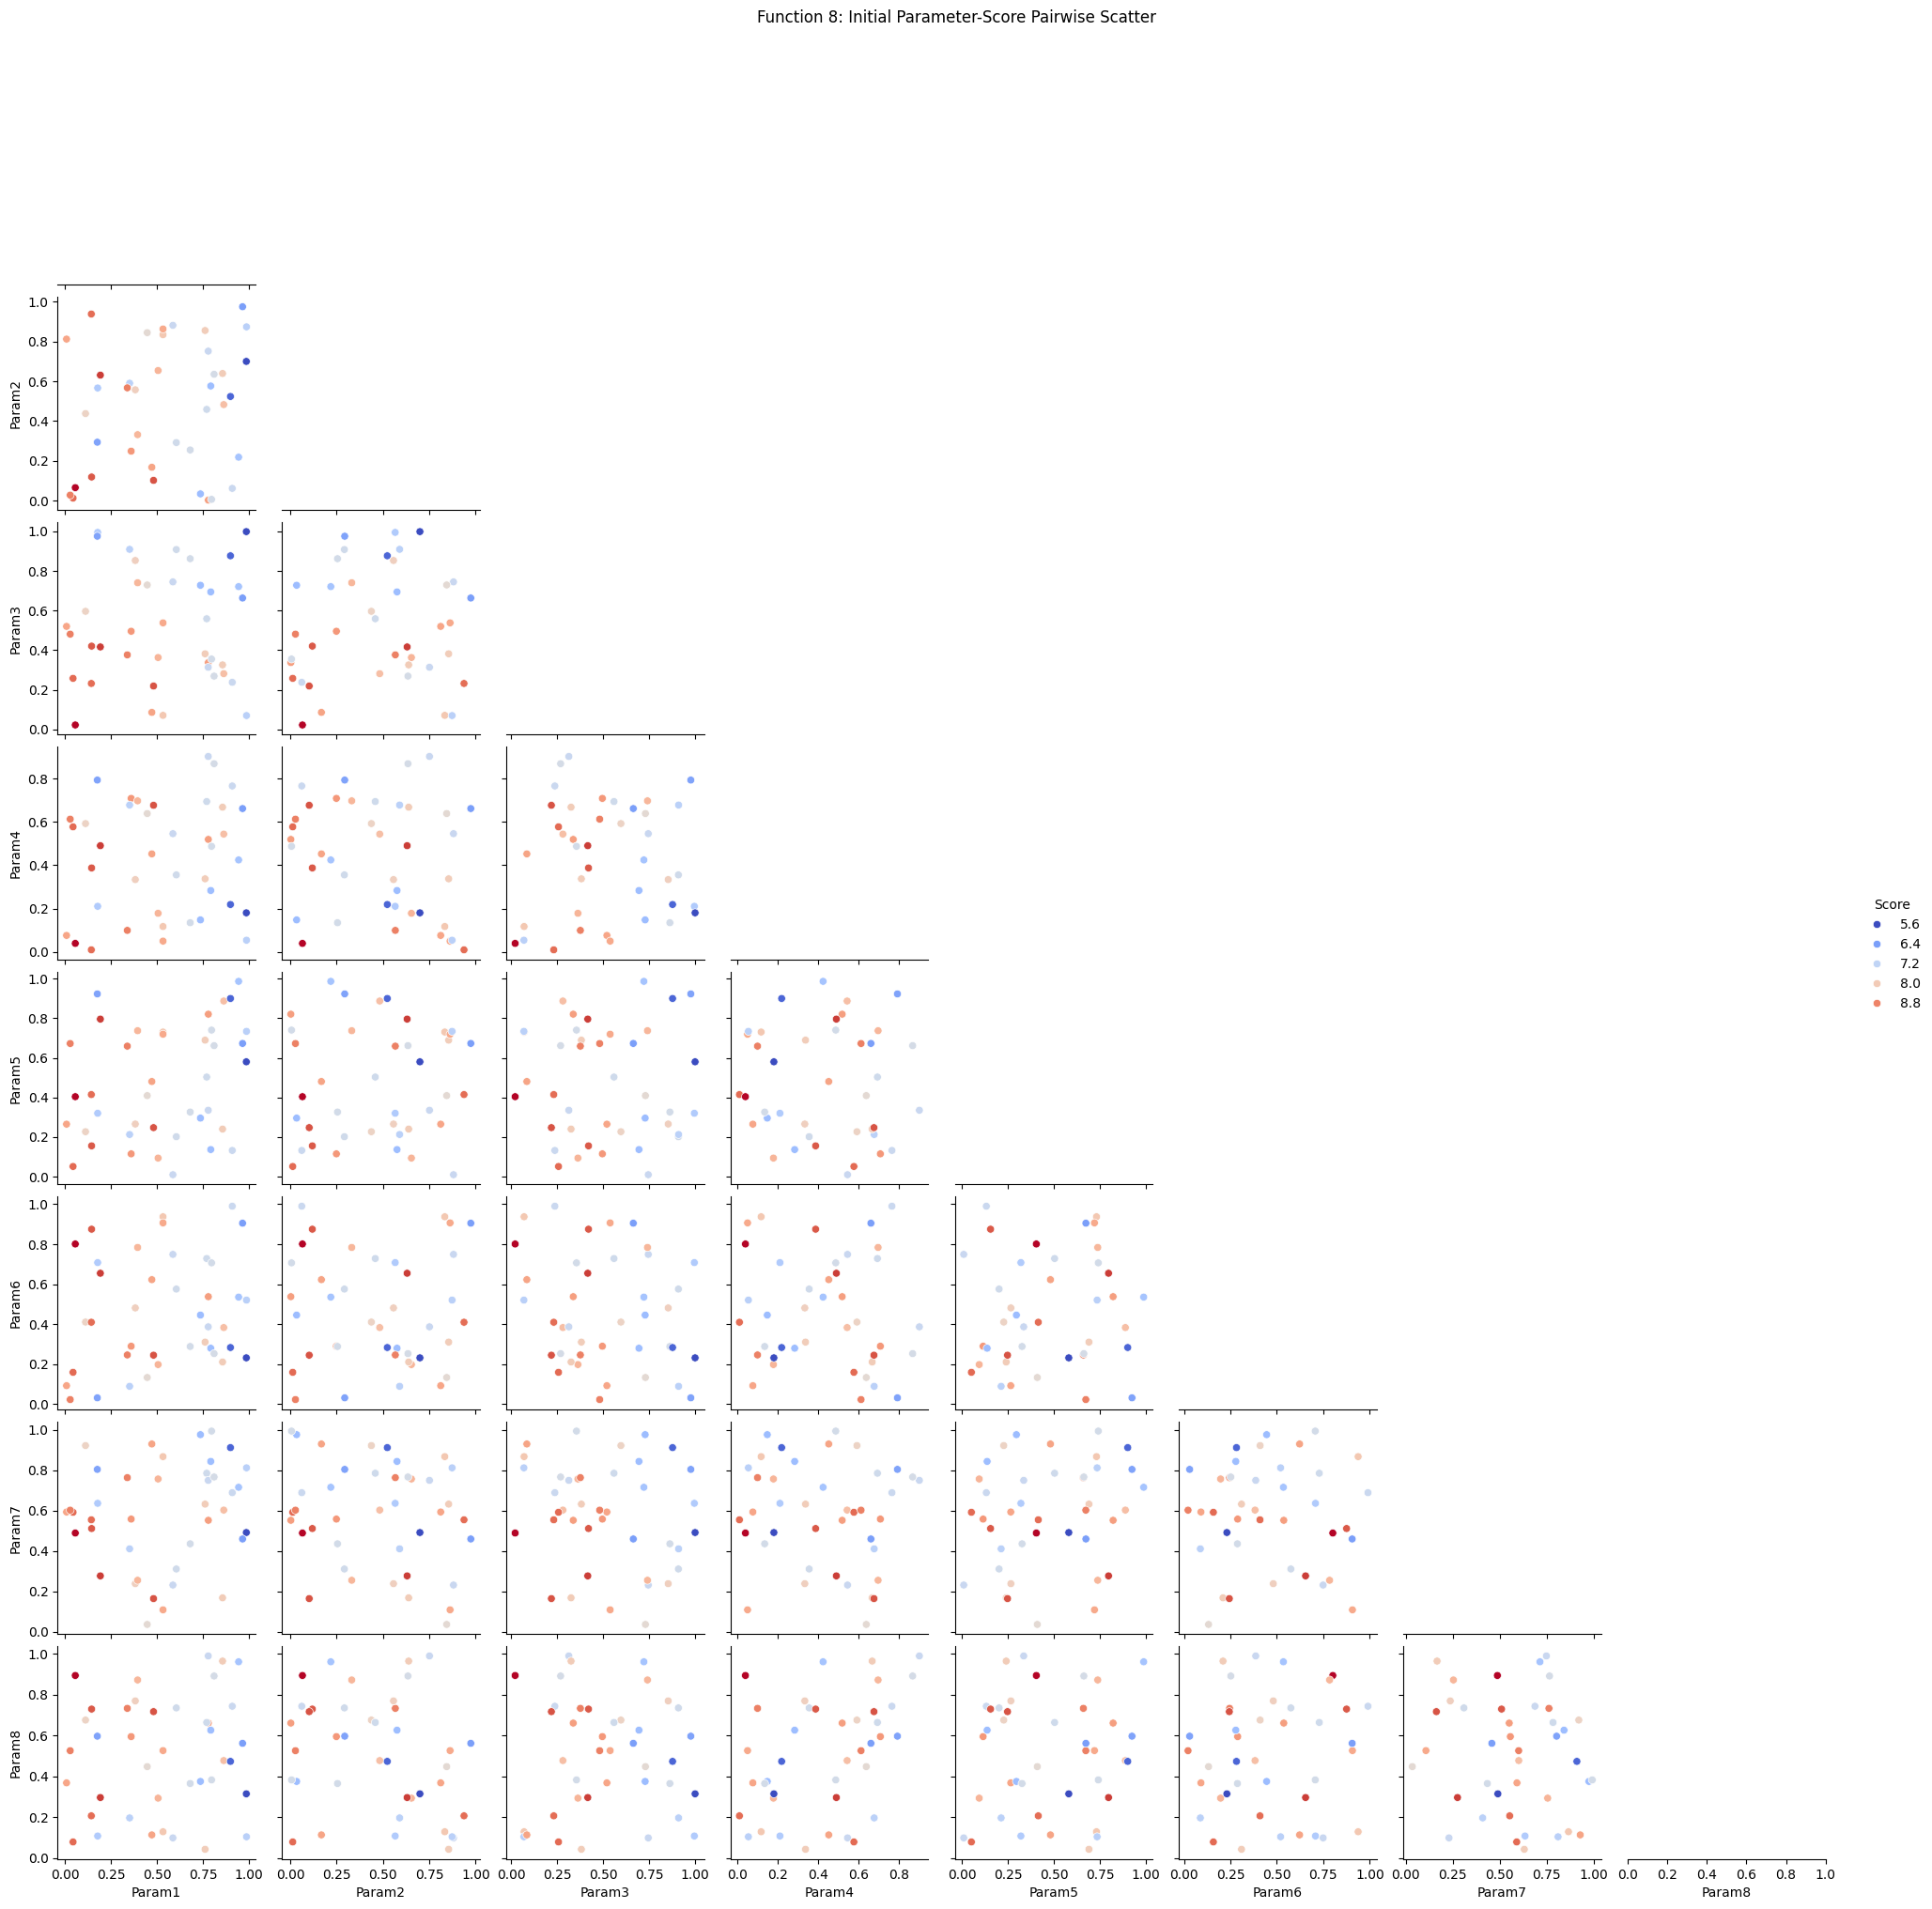

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1b: Pairwise scatter plots (for small number of hyperparams)
df = pd.DataFrame(inputs_f8, columns=[f'Param{i+1}' for i in range(8)])
df['Score'] = outputs_f8
sns.pairplot(df, hue='Score', palette='coolwarm', corner=True)
plt.suptitle('Function 8: Initial Parameter-Score Pairwise Scatter', y=1.02)
plt.show()

Fit the gaussian process

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# 2a. Kernel for smooth + noisy outputs
kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-2,1.0)) \
         + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6,1.0))



In [9]:

gp_f8 = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=10, random_state=42)
gp_f8.fit(inputs_f8, outputs_f8)
print("Optimized kernel:", gp_f8.kernel_)

Optimized kernel: 1.24**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.00801)


/opt/homebrew/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Step 3: Suggest the next point using UCB

Goal: maximize output (less negative)

In [10]:
# Sample candidate points in 8D
num_candidates = 50000  # more candidates due to 8D space
X_candidates = np.random.rand(num_candidates, 8)

# GP prediction
mu, sigma = gp_f8.predict(X_candidates, return_std=True)

# UCB acquisition: exploration first
kappa = 5.0  # high for exploration
UCB = mu + kappa * sigma

# Next suggested point
idx_next = np.argmax(UCB)
x_next = X_candidates[idx_next]

print("Next parameter combination suggested by BO:", x_next)

Next parameter combination suggested by BO: [0.20059526 0.01502866 0.06422919 0.13157426 0.8881259  0.02549247
 0.10523756 0.02464638]


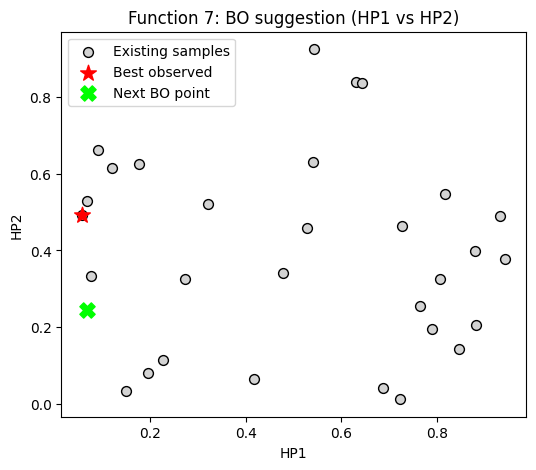

In [10]:
# Example: Flour vs Sugar
plt.figure(figsize=(6,5))
plt.scatter(inputs_f7[:,0], inputs_f7[:,1], c='lightgray', s=50, edgecolors='black', label='Existing samples')
plt.scatter(x_best[0], x_best[1], c='red', s=140, marker='*', label='Best observed')
plt.scatter(x_next[0], x_next[1], c='lime', s=120, marker='X', label='Next BO point')
plt.xlabel('HP1')
plt.ylabel('HP2')
plt.title('Function 7: BO suggestion (HP1 vs HP2)')
plt.legend()
plt.show()